# Goal: Compare actual monte carlo data to 1st and 2nd order expansions of initial states and parameters, both visually via sampling and in terms of moments, computed analytically or via sampling as well.

Once concluded, we can use the second order terms to determine the covariance impact on the mean

Also want to see if the entry dynamics produce natural asymmetries (i.e. without the saturation of a bank control), i.e. measure the skew of the true MC and second order expansion 

How big does covariance need to be in order to produce meaningful asymmetries? 

Idea: We don't generally need the entire covariance matrix. For example, we may only need altitude and downrange variances, skipping FPA and covariances to reduce the number of differential equations substantially. 

In [2]:
import sys, os
sys.path.append("./EntryGuidance")

from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat
import pickle
from time import time

from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
import chaospy as cp 
# import seaborn
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils.gpops import srp 

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 
from EntryGuidance.Triggers import AltitudeTrigger
from EntryGuidance.VMC import VMC, velocity_trigger, altitude_trigger
from EntryGuidance import Unscented 

np.set_printoptions(suppress=True, precision=3)

## Numerical Approach: Vectorized Monte Carlo

In [122]:
# sample inputs to be used in the comparison 
N = 1000

x0 = InitialState(vehicle='heavy')
print(x0)
P0 = np.diag([0.01, 0.0001, 0.0001, 1, np.radians(0.1), np.radians(0.1), 0.001])**2

Vf = 600
Vr = [4200, 500]
mc = VMC()
mc.null_sample(N)
X0 = mc.sample_state(x0, P0, N)
deltas = X0-x0[:,None]

def switch_controller(v_reverse):
    b1 = 90
    b2 = 20
    def _control(e,x,l,d):
        v = x[3]
        sigma = np.radians(b1)*np.ones_like(e)
        sigma[np.less_equal(v, v_reverse[0])] = -np.radians(b2)
        sigma[np.less_equal(v, v_reverse[1])] = np.radians(b2)
        return sigma

    return _control

mc.control = switch_controller(Vr)
# mc.set_trigger(velocity_trigger(Vf))
mc.set_trigger(altitude_trigger(6, 850))

[3522000.          0.          0.       5500.         -0.253       0.
    7200.   ]
 
Generating 1000 samples...


In [123]:
mc.run(X0, save=False, debug=False)

 
Running Monte Carlo...
Monte Carlo complete, time elapsed = 2.1 s.


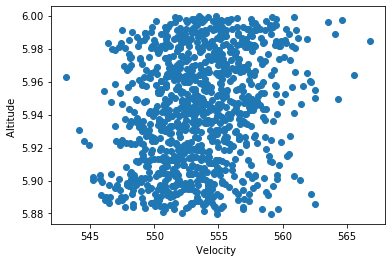

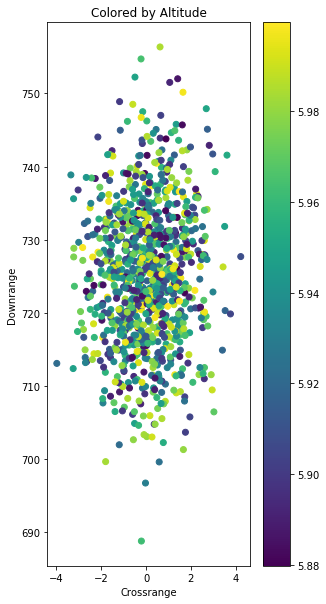

In [124]:
mc.plot()
# mc.plot_trajectories()

In [125]:
xf = mc.xf[:,:-1].copy()

xf[:,0] /= 1000
xf[:,0] -= 3397
xf[:,1] *= 3397 
xf[:,2] *= -3397
xf[:,4:6] = np.degrees(xf[:,4:6])

mean = np.mean(xf, axis=0)
std = np.std(xf, axis=0)
Pf = np.cov(xf, rowvar=False)

skew = np.mean((xf-mean)**3, axis=0)/std**3
print("Mean", mean)
print("Std ", std)
print("Skew", skew)  # r and gamma have a fair amount of skew 

Mean [  5.942 724.956   0.038 553.429 -12.973   6.87 ]
Std  [0.034 9.425 1.312 3.527 0.321 0.102]
Skew [-0.064  0.051  0.004  0.274  0.302 -0.035]


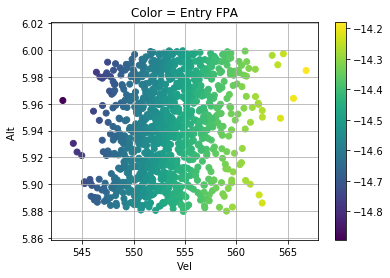

In [126]:
plt.figure()
plt.scatter(xf.T[3], xf.T[0], c=np.degrees(X0[4]))
plt.ylabel('Alt ')
plt.xlabel('Vel')
plt.title('Color = Entry FPA')
plt.colorbar()
plt.grid()

## Second Numerical Approach: Unscented Transform 

In [ ]:
N = 1000

x0 = InitialState(vehicle='heavy')
print(x0)
P0 = np.diag([0.01, 0.0001, 0.0001, 1, np.radians(0.1), np.radians(0.1), 0.001])**2

Vf = 600
Vr = [4200, 500]
mc = VMC()
mc.null_sample(N)
X0 = mc.sample_state(x0, P0, N)
deltas = X0-x0[:,None]

def switch_controller(v_reverse):
    b1 = 90
    b2 = 20
    def _control(e,x,l,d):
        v = x[3]
        sigma = np.radians(b1)*np.ones_like(e)
        sigma[np.less_equal(v, v_reverse[0])] = -np.radians(b2)
        sigma[np.less_equal(v, v_reverse[1])] = np.radians(b2)
        return sigma

    return _control

mc.control = switch_controller(Vr)
# mc.set_trigger(velocity_trigger(Vf))
mc.set_trigger(altitude_trigger(6, 850))

## Taylor Expansion Approach
We can either sample the Taylor polynomial or use our analytical equations

In [127]:
states = ['Entry']
trigger = [AltitudeTrigger(6)]
sim_config = {'states':states, 'conditions':trigger}
dasim = Simulation(cycle=Cycle(1), output=False, use_da=True, **sim_config, )
names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'm']
x0d = da.make(x0, names, 2)

def fuck(**d):
#     print(d['time'])
    return d['velocity']
def switch_controller_wrap(vr):
    control = switch_controller(vr)
    return lambda **d: control([0], [0,0,0,da.const(fuck(**d))], 0, 0)[0]

res = dasim.run(x0d, [switch_controller_wrap(Vr)])

In [157]:
# dasim.history = da.const(dasim.history, array=True)
# dasim.control_history = da.const(dasim.control_history, array=True)
# dasim.plot()
model = Entry()
XX = da.const(dasim.history, array=True)
UU = da.const(dasim.control_history, array=True)
XU = np.concatenate((XX.T, UU.T))
print(XU.shape)
AB = np.array([model.jacobian(xi, ui, vectorized=False) for xi,ui in zip(XX, UU)])
print(A.shape)
E = np.array([np.linalg.eig(submatrix(M,[0,1,3,4]))[0] for M in A])
print(E.shape)

(10, 2711)
(2711, 7, 10)
(2711, 4)


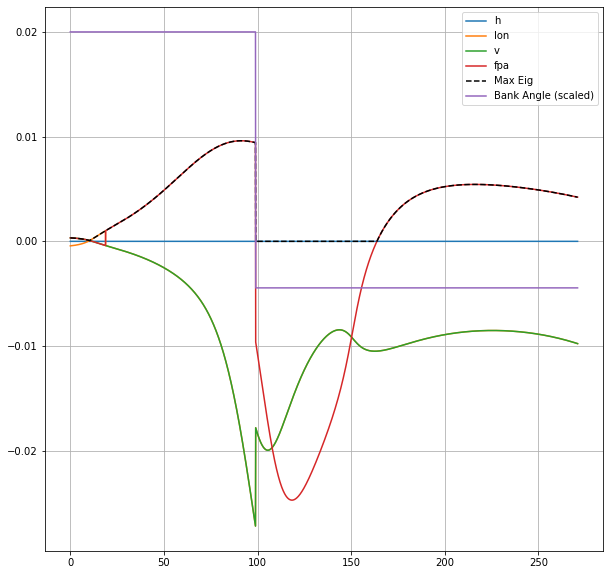

In [170]:
plt.figure(figsize=(10,10))
plt.plot(dasim.times, E )

plt.plot(dasim.times, np.max(E, axis=1), 'k--', label='Max Eig')
plt.plot(dasim.times, UU[:,0]/np.max(UU[:,0])/50, label='Bank Angle (scaled)')
plt.grid()
# plt.legend()
plt.legend(['h','lon','v','fpa','Max Eig','Bank Angle (scaled)'])

plt.show()

In [314]:
dasim.df.iloc[-1][4:10]

radius       -3.53287*dfpa*dr-0.00285025*dV**2-1.34585*dV+3...
longitude    -0.0158696*dpsi-1.54773e-08*dm**2+0.000285132*...
latitude     0.00337784*dphi*dpsi+0.00466005*dV*dfpa-4.9876...
velocity     1.49518e-06*dm*dr+9.35729*dV*dfpa+1.43338e-05*...
fpa          -18315.6*dfpa**2-2.60167e-06*dV**2-0.00318357*...
heading      -12.1954*dphi-0.000172147*dphi*dr-0.00616733*d...
Name: 2710, dtype: object

In [315]:
def moments(Z, P, names, linear=False):
    # Computes 2nd order analytical moments (1,2,3) of a DA array z with initial covariance P
    dn = ['d'+n for n in names]
    data = []
    for z in Z:
        z.extend_symbol_set(dn)
        J = da.gradient(z, names)
        H = 0.5*da.jacobian(da.differentiate(z, names), names)*(not linear)

        mean = z.find_cf([0]*len(names)) + np.trace(H.dot(P))
        var = J.dot(P).dot(J.T) + 2*np.trace(H.dot(P).dot(H).dot(P))
        std = np.sqrt(var)
        skew = (6*J.dot(P).dot(J.T)*np.trace(H.dot(P)) + 8*np.trace(H.dot(P).dot(H).dot(P).dot(H).dot(P)))/std**3 
        data.append([mean, std, skew])
    return np.array(data).T

In [316]:
# da.const(dasim.df.iloc[-1])

xf = dasim.df.iloc[-1].values[4:10].copy()
print(da.const(xf))

xf[0] /= 1000
xf[0] -= 3397
xf[1] *= 3397*np.pi/180
xf[2] *= -3397*np.pi/180
xf[4:6] = xf[4:6]
print(da.const(xf))

# print(deltas.shape)
Xf = da.evaluate(xf[:7], names, deltas.T).squeeze()
sample_mean = np.mean(Xf, axis=0)
# print(Xf.shape)

sample_std = np.std(Xf, axis=0)
sample_Pf = np.cov(Xf, rowvar=False)

sample_skew = np.mean((Xf-sample_mean)**3, axis=0)/sample_std**3

da_mean, da_std, da_skew = moments(xf, P0, names, linear=False)
print("\nMC Results:")
print("Mean", mean)
print("Std ", std)
print("Skew", skew)  # r and gamma have a fair amount of skew 

print("\nAnalytical from DA Coefficients:")
print("Mean", da_mean)
print("Std ", da_std)
print("Skew", da_skew)  # r and gamma have a fair amount of skew 

print("\nSamples from DA:")
print("Mean", sample_mean)
print("Std ", sample_std)
print("Skew", sample_skew)  # r and gamma have a fair amount of skew 

[3402999.955481705, 12.28940423044325, 0.01624177666527155, 557.9254512310335, -13.217463540995869, 7.073484203629138]
[5.999955481705001, 728.6244558603767, -0.9629560117832022, 557.9254512310335, -13.217463540995869, 7.073484203629138]

MC Results:
Mean [  5.939 724.147   0.245 552.725 -12.905   6.824]
Std  [0.034 9.379 1.284 3.467 0.326 0.1  ]
Skew [ 0.062  0.074 -0.004  0.301  0.256 -0.048]

Analytical from DA Coefficients:
Mean [  6.002 728.753  -0.959 559.086 -13.273   7.07 ]
Std  [ 1.142 10.977  1.67  37.805  1.335  0.138]
Skew [ 0.009  0.07   0.015  0.184 -0.25  -0.166]

Samples from DA:
Mean [  6.001 728.751  -0.959 559.08  -13.273   7.07 ]
Std  [ 1.14  10.961  1.679 37.759  1.334  0.136]
Skew [ 0.006  0.069 -0.012  0.177 -0.247 -0.194]


### Some observations: 
- There is very little difference between (sufficiently) sampling the DA model and using the analytical formula. 
- Even at N=1000, the MC was faster than integrating the second order DA variables. Prefer the samples unless derivatives are needed. The MC also doesn't slow if we include parametric uncertainty as well, while the DA approach will get even slower. 
- There is some discrepancy because the monte carlo samples are at a fixed velocity or fixed altitude while the DA variables are at a fixed time; Can I integrate wrt to energy?

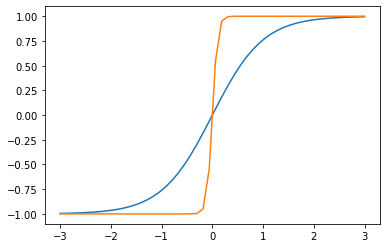

In [113]:
q = np.linspace(-3,3)
for beta in [1, 0.1]:
    plt.plot(q, np.tanh(q/beta))
    


In [119]:
H = np.random.random((3,3))
H = H.dot(H.T)
print(np.linalg.inv(H))

J = np.array([0.1, 0.5, -0.25])

def QC(L, J, H):
    A = np.linalg.inv(H - 2*L*np.eye(H.shape[0]))
    return J.dot(A).dot(A).dot(J)



[[   9.476  -60.647   29.55 ]
 [ -60.647  449.781 -231.228]
 [  29.55  -231.228  122.797]]


(201, 3)


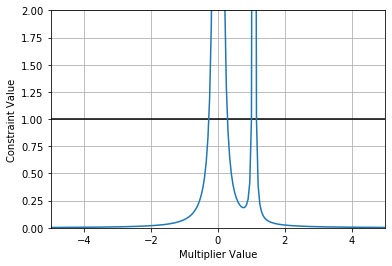

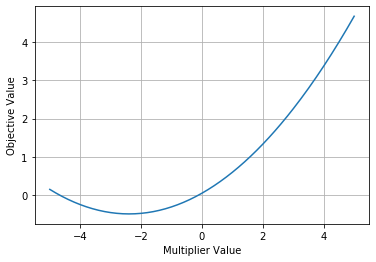

In [121]:
L = np.linspace(-5, 5, 201)
C = [QC(l, J, H) for l in L]
X = np.array([-J.dot(H-2*np.eye(3)*l) for l in L])
print(X.shape)
Obj = [J.dot(x.T) + 0.5*x.T.dot(H).dot(x) for x in X]

plt.figure()
plt.plot(L, C)
plt.hlines(1, L.min(), L.max(), color='k')
plt.axis([L.min(), L.max(), 0, 2])
plt.ylabel('Constraint Value')
plt.xlabel('Multiplier Value')
plt.grid()

plt.figure()
plt.plot(L, Obj)
# plt.hlines(1, L.min(), L.max(), color='k')
# plt.axis([L.min(), L.max(), 0, 2])
plt.ylabel('Objective Value')
plt.xlabel('Multiplier Value')
plt.grid()
plt.show()

# Test our propagation of mean/cov using samples instead of linear approx 
Use a linear scalar system with Gaussian uncertainty 
W/o saturation the true dist is gaussian 
Compare linear prop, sample prop, and full mc results 

### Benefits: can use full nonlinear controller, saturation effects accounted for
### Cons: assumes a normal distribution at each time step, can either under or over approximate the true values 

One possibility is to compute more moments, and sample from the distribution of maximum entropy at each timestep instead of a normal dist.

MC      : 125.7 ms
moments : 160.6 ms
DA      : 173.1 ms


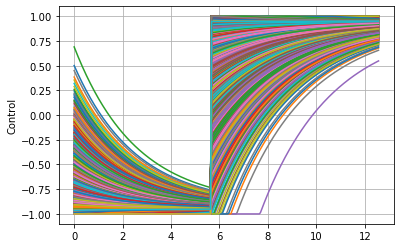

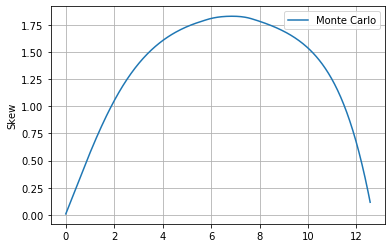

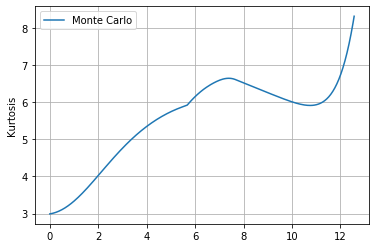

In [137]:
# Define our dynamics, controls, etc 
x0 = 0
k = 0.5
# k1 = np.sqrt(k)
k1 = 0.0
def u_nom(t,x=None):
    if t < 1.8*np.pi :
        return -0.95
    return 0.95

def dyn(x, t, ufun):
    a = 0.1
    b = 1
    dx = a*x + b*ufun(t,x) - 0.005*x**2
    return dx

def moment_dyn(x, t, samples):
    ## x is mean and variance
    m,v,skew = x 
    s = np.sqrt(max(0, v))
    X = m + s*samples
    dX = dyn(X, t, u)
    
    dm = np.mean(dX)
    dv = np.mean(2*X*dX) - 2*m*dm
    ds = np.mean(3*X**2*dX) - 3*dm*v - 3*m*dv - 3*m**2*dm # this is the deriv of the unnormalized skew 

    return np.array([dm, dv, ds])

P0 = 1**2
X0 = cp.Normal(x0, np.sqrt(P0)).sample(1000, 'L')
t = np.linspace(0, 4*np.pi, 300)

# Reference Trajectory 
xnom = RK4(dyn, x0, t, args=(u_nom,))
x_nom = interp1d(t, xnom)

u_nonlinear = lambda t,x: np.clip(-k*(x-x_nom(t)) + u_nom(t), -1, 1)
u_linear = lambda t,x: -k*(x-x_nom(t))  + u_nom(t)

u = u_nonlinear

timer = {}
# Monte Carlo
t0 = time()
X = RK4(dyn, X0, t, args=(u,))
timer['MC'] = time() - t0

U = [u(ti, xi) for ti,xi in zip(t,X)]

# Sample Stats
m = np.mean(X, axis=1)
s = np.std(X, axis=1)
skew = np.mean((X-m[:,None])**3, axis=1)/s**3
kurt = np.mean((X-m[:,None])**4, axis=1)/s**4

# Sample Based Moment Propagation
S = cp.Normal(0, 1).sample(500, 'L')
t0 = time()
M = RK4(moment_dyn, [x0, P0, 0], t, args=(S,)).T
timer['moments'] = time() - t0

# Differential Algebra to get linear approx 
x0_da = pa.gdual_double(x0, 'x', 1)
t0 = time()
x_da = RK4(dyn, [x0_da], t, args=(u_linear,)).squeeze()
timer['DA'] = time() - t0

m_da = da.const(x_da, array=True)
stm = da.jacobian(x_da, ['x'])**2
s_da = np.sqrt(stm*P0)

# Unscented Transform
xu,wm,wc = Unscented.Transform([x0], np.array([[P0]]), 4)
# print(xu, wm, wc)
Xu = RK4(dyn, xu, t, args=(u,))

mu = np.sum(Xu*wm[:,None], axis=1)
vu = np.sum((Xu-mu[:,None])**2*wc[:,None], axis=1)
for thing in timer:
    print("{:8}: {:.1f} ms".format(thing, timer[thing]*1000))

plt.figure()
plt.plot(t, U)
plt.ylabel('Control')
plt.grid()

plt.figure()
plt.plot(t, skew, label='Monte Carlo')
# plt.plot(t, M[2]/(M[1]**1.5), label='Moment Prop')
plt.ylabel('Skew')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, kurt, label='Monte Carlo')
# plt.plot(t, M[2]/(M[1]**1.5), label='Moment Prop')
plt.ylabel('Kurtosis')
plt.legend()
plt.grid()

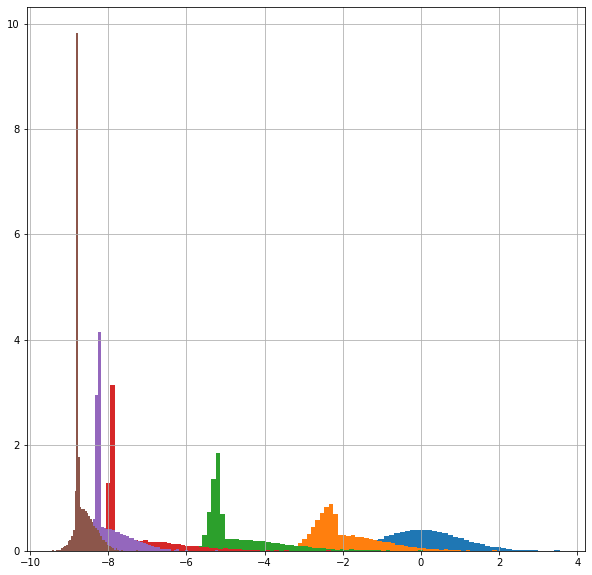

In [138]:
plt.figure(figsize=(10,10))
for xi in X[0:-1:50]:
    plt.hist(xi, bins=50, density='True')
    
plt.grid()

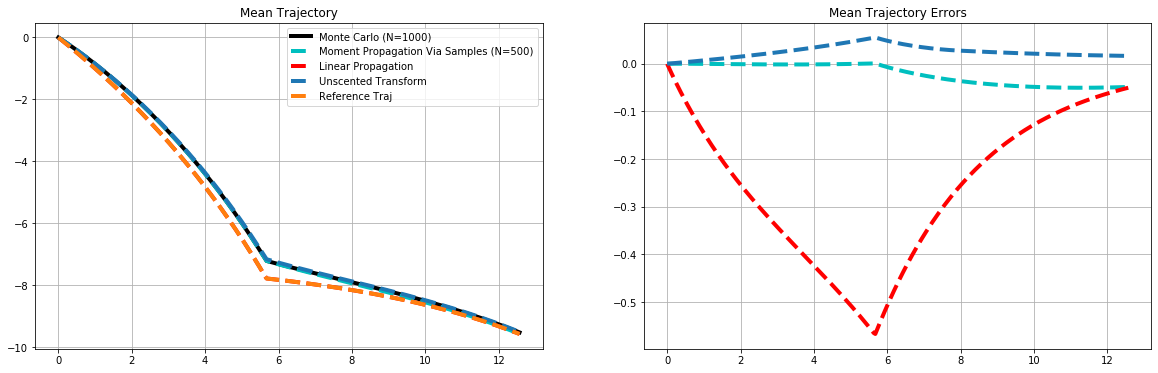

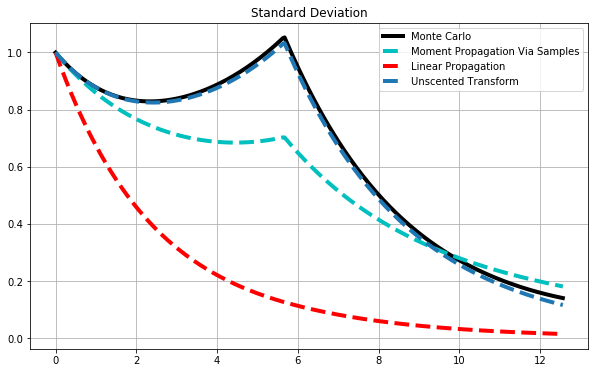

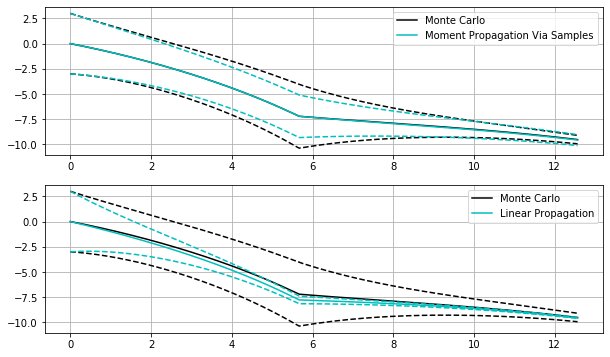

In [151]:
xu,wm,wc = Unscented.Transform([x0], np.array([[P0]]), 0.6)
# print(xu, wm, wc)
Xu = RK4(dyn, xu, t, args=(u,))

mu = np.sum(Xu*wm[:,None], axis=1)
vu = np.sum((Xu-mu[:,None])**2*wc[:,None], axis=1)

opts = {'linewidth': 4}
# Just means
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Mean Trajectory')
plt.plot(t, m, 'k', label='Monte Carlo (N={})'.format(X0.size), **opts)
plt.plot(t, M[0], 'c--', label='Moment Propagation Via Samples (N={})'.format(S.size), **opts)
plt.plot(t, m_da, 'r--', label='Linear Propagation', **opts)
plt.plot(t, mu, '--', label='Unscented Transform', **opts)
plt.plot(t, xnom, '--', label='Reference Traj', **opts)

plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title('Mean Trajectory Errors')
plt.plot(t, M[0]-m, 'c--', label='Moment Propagation Via Samples (N={})'.format(S.size), **opts)
plt.plot(t, m_da-m, 'r--', label='Linear Propagation', **opts)
plt.plot(t, mu.squeeze()-m, '--', label='Unscented Transform', **opts)
plt.grid()

# Just stds
plt.figure(figsize=(10,6))
plt.title('Standard Deviation')
plt.plot(t, s, 'k', label='Monte Carlo', **opts)
plt.plot(t, np.sqrt(M[1]), 'c--', label='Moment Propagation Via Samples', **opts)
plt.plot(t, s_da, 'r--', label='Linear Propagation', **opts)
plt.plot(t, np.sqrt(vu), '--', label='Unscented Transform', **opts)

plt.legend()
plt.grid()
# One on one with truth 
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 1)
plt.plot(t, m, 'k', label='Monte Carlo')
plt.plot(t, m+3*s, 'k--')
plt.plot(t, m-3*s, 'k--')

plt.plot(t, M[0], 'c', label='Moment Propagation Via Samples')
plt.plot(t, M[0]+3*np.sqrt(M[1]), 'c--')
plt.plot(t, M[0]-3*np.sqrt(M[1]), 'c--')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, m, 'k', label='Monte Carlo')
plt.plot(t, m+3*s, 'k--')
plt.plot(t, m-3*s, 'k--')

plt.plot(t, m_da, 'c', label='Linear Propagation')
plt.plot(t, m_da+3*s_da, 'c--')
plt.plot(t, m_da-3*s_da, 'c--')

plt.legend()
plt.grid()

## Primary conclusion: saturation is the main driver of poor performance in linear propagation - mild nonlinearities are not the dominant source, even for large initial covariance
## Unscented Transform outperforms my method 

## Realization: differential algebra can compute adjoint sensitivities by simply integrating backwards from a final state and initializing the terminal state as DA vars. Note that this actually still requires inverting matrices, saving essentially no computation time...

Text(0.5, 1.0, 'Nominal Traj')

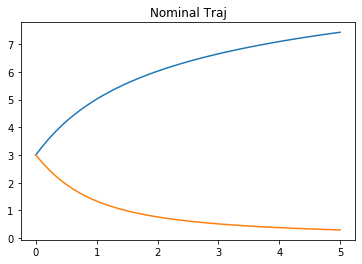

In [116]:
def test_dynamics(x, t, u=0):
    dx = np.array([x[1], -0.1*x[0]*x[1]**2 + u])
    return dx

x0 = [3,3]
t = np.linspace(0, 5)
x = RK4(test_dynamics, x0, t)
plt.plot(t,x)
plt.title('Nominal Traj')


In [34]:
# Forward DA, then use matrix inversion to compute adjoint sensitivities
X0 = da.make(x0, ['x','v'], 1)
U = da.make([0], 'u', 1)[0]
names = ['x','v','u']
X = RK4(test_dynamics, X0, t, args=(U,))
X[-1]

array([0.496754*dv+0.546429*dx+4.35926*du+7.42846,
       -0.0106337*dv+0.298052+1.54691*du-0.0315672*dx], dtype=object)

In [117]:
STM = np.array([da.jacobian(XDA, names) for XDA in X])
STM.shape
def make_square(M):
    """ Appends rows until M is square. Main diagonal elements are set to one and the rest zeros.
    Useful in inverting differential algebraic quantities
    """
    n,m = M.shape
    if n == m:
        return M 
    assert m > n, "Expected a matrix with more columns than rows"
    I = np.eye(m)[n:]
    M_square = np.vstack([M,I])
        
    return M_square
STMi = np.array([np.linalg.inv(make_square(stm)) for stm in STM])
STMi.shape

adj = np.array([make_square(STM[-1]).dot(stmi) for stmi in STMi])

# plt.figure()
# plt.plot(t, adj[:, 0])
# plt.title('Terminal State 1 Sensitivities to IC and Control')
# plt.legend(['x0','v0','du'])

# plt.figure()
# plt.title('Terminal State 2 Sensitivities to IC and Control')
# plt.plot(t, adj[:, 1])
# plt.legend(['x0','v0','du'])


In [118]:
# Backward DA
XF = da.make(x[-1], ['x','v'], 1)
print(x[-1])
print(XF)
# names = ['x','v','u']
Xb = RK4(test_dynamics, XF, -t, args=(U,))
tb = t[-1] - t

adjb = np.array([np.linalg.inv(make_square(da.jacobian(xb, names))) for xb in Xb])
adjb.shape

[7.428 0.298]
[7.42846+dx, dv+0.298052]


(50, 3, 3)

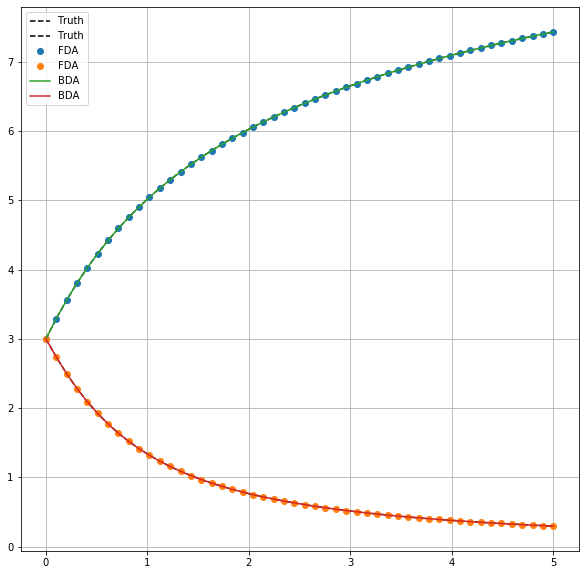

In [119]:
# Plot the nominal trajectories to verify backward integration
plt.figure(figsize=(10,10))
plt.plot(t, x, 'k--', label='Truth')
plt.plot(t, da.const(X), 'o',label='FDA')
plt.plot(tb, da.const(Xb), label='BDA')
plt.legend()
plt.grid()
plt.show()

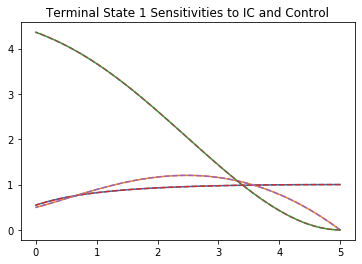

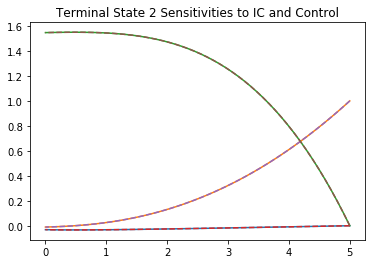

In [120]:
# plt.figure()
# plt.plot(t[-1] - t, adjb[:, 0])
# plt.legend(['x0','v0','du'])

# plt.figure()
# plt.plot(tb, adjb[:, 1])
# plt.legend(['x0','v0','du'])

plt.figure()
plt.plot(t, adj[:, 0])
plt.plot(tb, adjb[:, 0], '--')

plt.title('Terminal State 1 Sensitivities to IC and Control')
# plt.legend(['x0','v0','du'])

plt.figure()
plt.title('Terminal State 2 Sensitivities to IC and Control')
plt.plot(t, adj[:, 1])
plt.plot(tb, adjb[:, 1], '--')

# plt.legend(['x0','v0','du'])

## Confirmed, both methods of computing adjoint sensitivities give the same result.

In [19]:
# Next, create a similar mean/covariance integrator for the entry equations. Takes a mean and cov and samples (of state) and vectorized model (for parametric uncertainty, if any)

def standard_transform(covariance):
    """ Finds diagonalizing transform and its inverse """
    values, vectors = np.linalg.eig(covariance)
    Vi = np.linalg.inv(vectors)
    T = vectors.T.dot(np.diag(values**-0.5)).dot(Vi)
    Ti = vectors.T.dot(np.diag(values**0.5)).dot(Vi)

    return T,Ti
    
def standardize(data):
    """ Returns the data with zero mean and identity covariance matrix, 
    as well as the transform variables m and T such that
    data ~ m + T*N where N is a standard mvnormal distribution
    """
    m = np.mean(data, axis=1, keepdims=True)
    c = np.cov(data) # need correct axis'
    T,Ti = standard_transform(c)
    d = T.dot(data-m)
    return d, m, Ti

class Moments:
    """ Vector Mean  + Covariance Matrix state vector and utilities. Can be used for derivatives as well. """
    def __init__(self, mean, covariance):
        
        covariance = np.asarray(covariance)
        
        self.n = len(mean)
        # Ensure square cov and matching length to means 
        assert covariance.shape[0] == self.n, "# of rows in covariance matrix ({}) =/= length of mean vector ({})".format(covariance.shape[0], self.n)
        assert covariance.shape[1] == self.n, "# of cols in covariance matrix ({}) =/= length of mean vector ({})".format(covariance.shape[1], self.n)

        self.m = np.array(mean).squeeze()
        self.c = covariance
        
        # don't do this by default since C could be a derivative and thus not positive definite 
        self.Ti = None 

    
    def __len__(self):
        return self.n
    
    def __str__(self):
        return "Mean: {}\nCov: \n{}".format(self.m, self.c)
    
    def __add__(self, moments):
        return Moments(self.m + moments.m, self.c + moments.c)
    
    def __sub__(self, moments):
        return Moments(self.m - moments.m, self.c - moments.c)
        
    def __mul__(self, scalar):
        return Moments(self.m*scalar, self.c*scalar)
    
    def __neg__(self):
        return self.__mul__(-1)
    
    def __rmul__(self, scalar):
        return self.__mul__(scalar)
    
    def array(self):
        return self.m, self.c
    
    def __call__(self):
        return self.array()
    
    def copy(self):
        return Moments(self.m, self.c)
    
    def generate_standard_normal(self, N, method='L'):
        """ Create a set of of samples drawn from a multivariate standard normal"""
        return cp.MvNormal([0]*self.n, np.diag([1]*self.n)).sample(N, method)
    
    def transform_samples(self, S):
        """ Samples should be n states x N samples """
        if self.Ti is None:
            T,Ti = standard_transform(self.c)
            self.T  = T
            self.Ti = Ti
        return self.m[:,None] + self.Ti.dot(S) # maybe squeeze this 
    
    def generate_samples(self, N, method='L'):
        return self.transform_samples(self.generate_standard_normal(N, method))
      
def test_moments():
    x0 = [0,1,0]
    P0 = np.diag([1,2,3])
    M = Moments(x0, P0)
    print(len(M))
    print(M+M)
    print(-M-M)

    print(M*3)
    print(2*M)
    
    try:
        Moments(x0[:2], P0)

    except AssertionError:
        print("Correctly caught mis-sized inputs")
        
        
# test_moments()

x0 = [3,1,2]
P0 = np.diag([1,2,3])
M0 = Moments(x0, P0)
S = M0.generate_standard_normal(10)
S0 = M0.transform_samples(S)
print(S.shape, S0.shape)
def test_dyn(M, t):
    return -0.1*M

# M = RK4(test_dyn, M0, [0, 0.5, 10])
# print(M[-1])

class MomentDynamics:
    
    def __init__(self, model, samples):
        """ Model could be scalar parameters or vector with same number of samples """
        self.model = model
        self.samples = samples
        
    def dynamics(M, t,):
        x = M.transform_samples(self.samples)
        dx = self.model(x, t)
        
        # dx assumed to be n x N just like x 
        dm = np.mean(dx, axis=1)
        mdm = np.outer(m, dm)
        xdx = np.einsum('ik,jk->kij', x, dx) # vectorized outer product, N x n x n 
        dv = np.mean(xdx + np.transpose(xdx, (0, 2, 1)), axis=0) - (mdm + mdm.T)
        
        return Moments(dm, dv)


(3, 10) (3, 10)


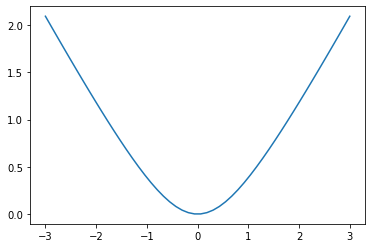

In [154]:
def PseudoHuber(p, k=0.01):
    """ Linear-like away from 0, quadratic near zero, positive second derivative 
    Wiki:
     It combines the best properties of L2 squared loss and L1 absolute loss by 
     being strongly convex when close to the target/minimum and less steep for extreme values.
    
    """
    return np.sqrt(p**2 + k**2) - k

q = np.linspace(-3, 3)
plt.plot(q, PseudoHuber(q, 1.1))

In [34]:
x = [1, 2, 3]
y = [0, 0, 1]
# np.einsum('i,j->ij', y, x)
np.outer(x,y)

array([[0, 0, 1],
       [0, 0, 2],
       [0, 0, 3]])

In [39]:
S = np.random.random((4, 5000))

t0 = time()
S2 = np.array([np.outer(s,s) for s in S.T])
t1 = time() - t0
print(S2.shape)

t20 = time()
Se = np.einsum('ik,jk->kij' , S, S)
t2 = time() - t20

print(np.allclose(S2, Se))

print(t1, t2)
# print(S2, Se)

(5000, 4, 4)
True
0.027270078659057617 0.0


In [459]:
# Gaussian splitting? For what purpose? Adapt distribution description 
class GMM:
    """ Univariate Gaussian Mixture """
    def __init__(self, means, stds, weights):
        self.N = len(means)
        assert len(means) == len(stds)
        assert len(means) == len(weights)
        
        self.m = means
        self.s = stds
        self.w = weights
        self.n = [cp.Normal(self.m[i], self.s[i]) for i in range(self.N)]
        self.sn = cp.Normal(0, 1) # have a standard normal available 
        
    def pdf(self, x):
        return np.sum([self.w[i]*self.n[i].pdf(x) for i in range(self.N)], axis=0)

    def cdf(self, x):
        return np.sum([self.w[i]*self.n[i].cdf(x) for i in range(self.N)], axis=0)
    
    def split(self, i, new=False):
        """ Splits the ith component into 3 components """
        assert i < self.N, "Cannot split component {}: GMM has only {} components".format(i, self.N)
        # the mean/std/weights for splitting a standard normal 
        sw = (self.s[i]**2 + np.dot(self.w, self.m)**2 - np.dot(self.w, np.power(self.m, 2)))**0.5
        print(sw)
        
        m, s, w = [self.m[i] -1.0575, self.m[i], self.m[i] + 1.0575], [0.6715663*sw]*3, [0.22522*self.w[i], 0.54955*self.w[i], 0.22522*self.w[i]]
        
        M = self.m[:i] + m + self.m[i+1:]
        S = self.s[:i] + s + self.s[i+1:]
        W = self.w[:i] + w + self.w[i+1:]
        
        if new:
            return GMM(M, S, W) # return or just update this one? Can we recall __init__?
        else:
            self.__init__(M, S, W)
        
    
Split3 = GMM([-1.0575, 0, 1.0575], [0.6715663]*3, [0.22522, 0.54955, 0.22522])
Split5 = GMM([-1.68997, -0.8009, 0, 0.8009, 1.68997], [0.4422555]*5, [0.076321, 0.247441, 0.35247, 0.247441, 0.076321])

Three Component GMM:


<Figure size 432x288 with 0 Axes>

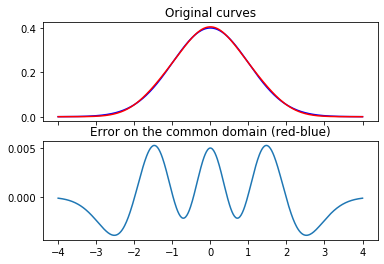

Five Component GMM:


<Figure size 432x288 with 0 Axes>

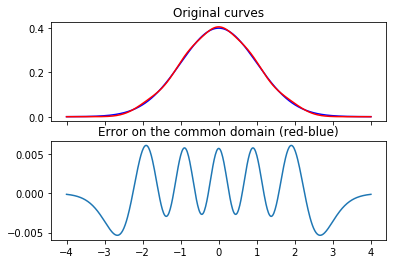

In [416]:
S = np.linspace(-4,4, 500)

D = cp.Normal(0, 1)
P = D.pdf(S)
C = D.cdf(S)

p3 = Split3.pdf(S)
c3 = Split3.cdf(S)

p5 = Split5.pdf(S)
c5 = Split5.cdf(S)

# plt.figure()
# plt.plot(S, P)
# plt.plot(S, p3, '--')
# plt.plot(S, p5, '--')

# plt.figure()
# plt.plot(S, C)
# plt.plot(S, c3, '--')
# plt.plot(S, c5, '--')

from Utils.compare import compare
print("Three Component GMM:")
compare(S, P, S, p3, plot=True)
plt.show()
print("Five Component GMM:")
compare(S, P, S, p5, plot=True)

plt.show()

2.0
[Normal(mu=-1.0575, sigma=1.3431326), Normal(mu=0, sigma=1.3431326), Normal(mu=1.0575, sigma=1.3431326)]


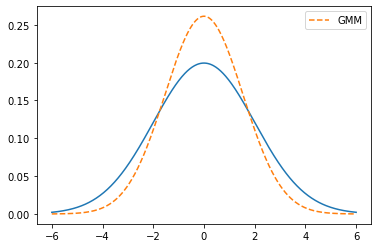

In [460]:
# Make sure we know how to use these for non-standard normals 
m = 0
s = 2
S = m + np.linspace(-3*s, 3*s, 500)

D = cp.Normal(m, s)
P = D.pdf(S)
C = D.cdf(S)

gmm = GMM([m], [s], [1])
gmm.split(0)

print(gmm.n)

p3 = gmm.pdf(S)
c3 = gmm.cdf(S)

plt.figure()
plt.plot(S, P)
plt.plot(S, p3, '--', label='GMM')
plt.legend()

# plt.figure()
# plt.plot(S, C)
# plt.plot(S, c3, '--')


In [419]:
gmm.sn

Normal(mu=0, sigma=1)

## Idea: Use unscented transform or stochastic linearization to propagate mean/std, solve in GPOPS using LQR gains (heavy penalty on terminal states/range) and min mean + cov objective. Start with LQR outside of optimization? I.e. solve for gains and interp as function of velocity? 



In [24]:
P = np.diag([1,2,4.]) 
dP = 0.25*np.random.randn(*P.shape)
P += dP.dot(dP.T)

assert np.min(np.linalg.eig(P)[0]) > 0, "P is not pos def"
print(P)
S = np.linalg.cholesky(P)
print("Is square root matrix correct:", np.allclose(P, S.dot(S.T)))
# print(S.T.dot(S)) # NOT the same
print("\nStandard Deviations:")
print(np.diag(P)**0.5)
print("Diagonal of S with SS^T = P")
print(np.diag(S))  # The same when P is positive definite 

print("\n")
A = np.random.random(P.shape) # Linear Transform 
print(A.dot(S))
print(np.linalg.cholesky(A.dot(P).dot(A.T)))

[[ 1.101 -0.066  0.076]
 [-0.066  2.343 -0.035]
 [ 0.076 -0.035  4.062]]
Is square root matrix correct: True

Standard Deviations:
[1.049 1.531 2.015]
Diagonal of S with SS^T = P
[1.049 1.529 2.014]


[[0.581 0.193 0.342]
 [0.157 0.055 1.861]
 [0.844 0.291 2.009]]
[[0.701 0.    0.   ]
 [1.053 1.544 0.   ]
 [1.758 1.319 0.009]]
